# Convolution

Convolution is the mathematical procedure that defines or represents the action of a linear and time-invariant (LTI) system on an input signal.  Specifically, if a system with an impulse response $h(t)$ is driven by an input signal $x(t)$, then the output is
$$
y(t) = h(t) \ast x(t) = \int_{-\infty}^{\infty} h(\lambda) x(t - \lambda) d\lambda.
$$
Every LTI system has an impulse response $h(t)$, which is the output when the input is the signal $x(t) = \delta(t)$.

The expression above is useful if you have expressions for the signals such as $h(t) = e^{-t} u(t)$ and $x(t) = u(t)$, and a symbolic math package can help in this case.  However, in reality we can't specify the signals we see and care about using simple analytical expressions, particularly for input and output signals.  Yet we still want to work with them.

We saw in a previous lab that if signals are bandlimited then they can be reconstructed from discrete samples.  In other words, the discrete signal $x[n]$ obtained by sampling a continuous-time bandlimited $x(t)$ according to $x[n] = x(nT)$ can be used to represent or reconstruct $x(t)$.  If we have a symbolic expression for the impulse response, which is often the case, then we can use the sampled input to generate samples from the corresponding output.  If all signals involved are represented using samples, then it turns out that we can effectively consider convolution in continuous-time using discrete-time convolution on the samples of the signals involved.  This lab explores all of these concepts and their application.

## Representing a continuous-time signal from samples

A previous lab investigated the topic of reconstructing a continuous-time bandlimited signal $x(t)$ from a sampled representation $x[n]$, with $x[n] = x(nT)$.  The process involves using the discrete signal $x[n]$ to construct a modulated impulse train 
$$x_s(t) = \sum_{n=-\infty}^{\infty} x[n] \delta(t-nT).$$
This is an interesting signal that has both continuous-time and discrete-time characteristics:  it is formulated on the continuous-time axis, but contains exactly and only the information contained in the samples $x[n]$.  As such it forms the link between the two domains.  The signal $x_s(t)$ is then filtered with a reconstruction filter $b_T(t)$ to interpolate between the sample points: 
$$x(t) = x_s(t) \ast b_T(t).$$
The ideal reconstruction filter is the *sinc* function that corresponds to perfect bandlimiting.

The cell below plots the two example signals mentioned above, which will be used for demonstration.  Also shown is the discrete set of values obtained by sampling the signals with a spacing $T$, starting at $n=0$.  It should be noted that neither of these signals are in fact bandlimited, so there will be errors in the approximation, but these errors will be reduced as $T$ becomes smaller.

<IPython.core.display.Javascript object>


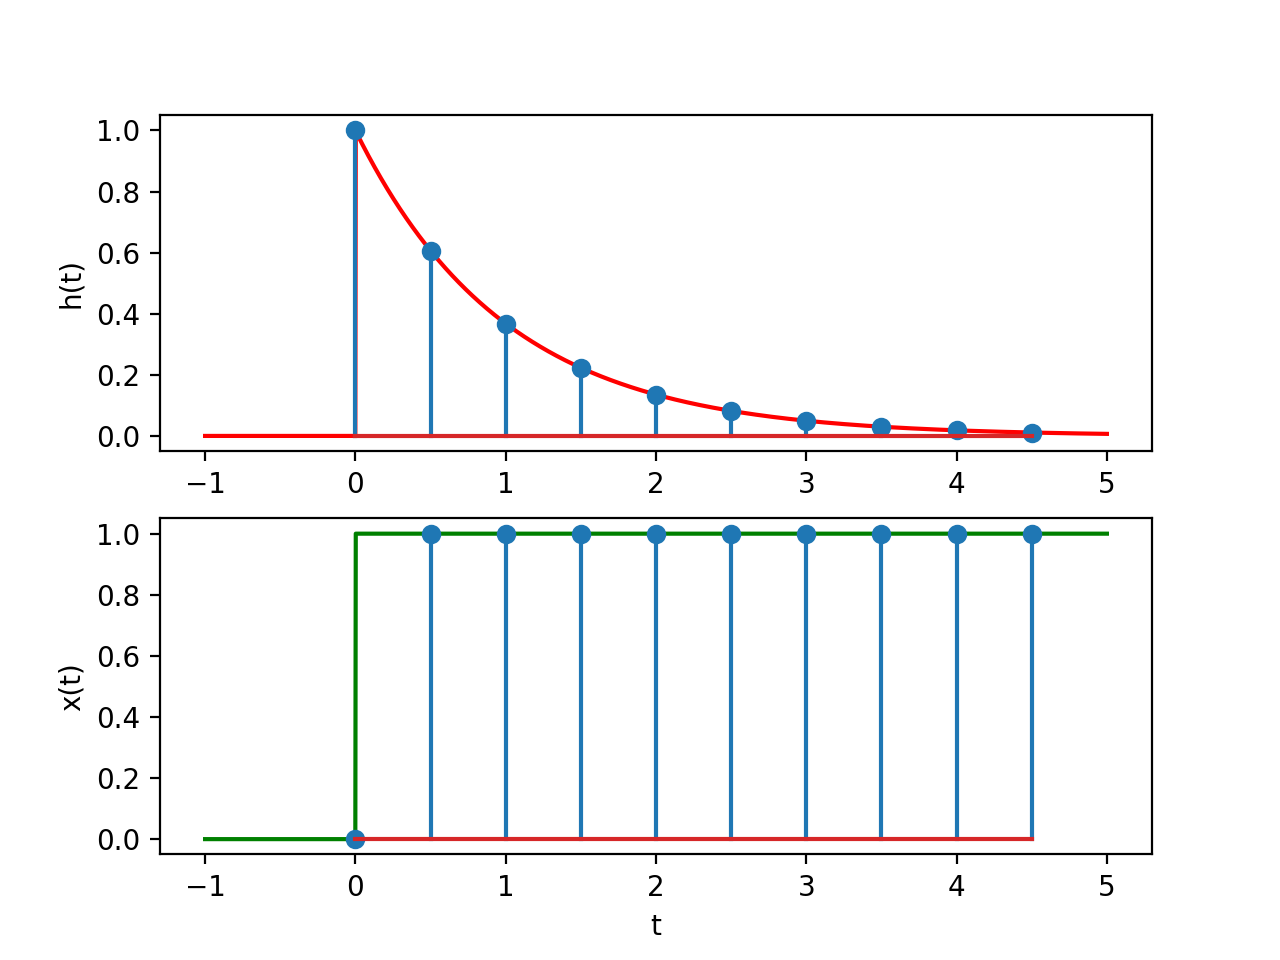

In [178]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Dense set of values for plotting underlying functions
tvp = np.linspace(-1, 5, 2000);
hvp = np.where(tvp<0, 0, np.exp(-tvp));  
xvp = np.where(tvp<0, 0, 1);
yvp = np.where(tvp<0, 0, 1-np.exp(-tvp));

# Discrete samples starting from n=0
T = 0.5;  nv = np.arange(0,np.floor(np.max(tvp)/T),1,np.int32);
tv = nv*T;
hv = np.where(tv<0, 0, np.exp(-tv));  
xv = np.where(tv<=0, 0, 1);

# Plots
fh = plt.figure;
plt.subplot(211);  plt.plot(tvp,hvp,'r-');  plt.stem(tv,hv);  plt.ylabel('h(t)');
plt.subplot(212);  plt.plot(tvp,xvp,'g-');  plt.stem(tv,xv);  plt.ylabel('x(t)');  plt.xlabel('t');

## Fully discrete convolution

Suppose now that we want to numerically approximate the convolution
$$y(t) = h(t) \ast x(t).$$
If $h(t)$ and $x(t)$ are bandlimited then we can sample them according to $h[n] = h(nT)$ and $x[n] = x(nT)$, and the following reconstruction formulae hold:
$$x(t) = x_s(t) \ast b_T(t) \qquad \text{and} \qquad
h(t) = h_s(t) \ast b_T(t).$$
The quantity $h_s(t)$ is the modulated impulse train corresponding to $h(t)$, namely
$$h_s(t) = \sum_{k=-\infty}^{\infty} h[k] \delta(t-kT),$$
and $b_T(t)$ is a reconstruction filter.

If we use an ideal lowpass reconstruction filter then $b_T(t) \ast b_T(t) = T b_T(t)$, and the required convolution is given by
$$
y(t) = (x_s(t) \ast b_T(t)) \ast (h_s(t) \ast b_T(t))
= x_s(t) \ast h_s(t) \ast T b_T(t).
$$
If any other reasonable reconstruction filter is used then this expression can be considered approximate.

Since $y(t)$ is the result of a convolution with $b_T(t)$ it is also bandlimited, and can be expressed as $y(t) = y_s(t) \ast b_T(t)$.  We must  therefore have the following:
\begin{align}
  y_s(t) &= T x_s(t) \ast h_s(t) = T \int_{-\infty}^{\infty} x_s(\lambda) h_s(t-\lambda) d\lambda \\
  &= T \int_{-\infty}^{\infty} \sum_{k=-\infty}^{\infty} x[k] \delta(\lambda-kT) \sum_{m=-\infty}^{\infty} h[m] \delta(t-\lambda-mT) d\lambda \\
  &= T \sum_{m=-\infty}^{\infty} \sum_{k=-\infty}^{\infty} x[k] h[m] \int_{-\infty}^{\infty} \delta(\lambda-kT) \delta(t-\lambda-mT) d\lambda \\
  &= T \sum_{m=-\infty}^{\infty} \sum_{k=-\infty}^{\infty} x[k] h[m] \delta(t-kT-mT) 
\end{align}

The steps above follow because the order of summation doesn't usually matter (which is probably true for the signals we care about), and the integral can be evaluated using the sifting property of the Dirac delta.

The change of variables $m=n-k$ is useful, and gives the result
\begin{align}
y_s(t) &= T \sum_{n=-\infty}^{\infty} \sum_{k=-\infty}^{\infty} x[k] h[n-k] \delta(t-kT-(n-k)T) \\
  &= \sum_{n=-\infty}^{\infty} \left( T \sum_{k=-\infty}^{\infty} x[k] h[n-k] \right) \delta(t-nT) \\
  &= \sum_{n=-\infty}^{\infty} y[n] \delta(t-nT) 
\end{align}
where we have let
$$
y[n] = T \sum_{k=-\infty}^{\infty} x[k] h[n-k].
$$
This is the operation corresponding to discrete-time convolution:  it takes the discrete-time signals $x[n]$ and $h[n]$, and combines them to produce the discrete time output $y[n]$.  We use the same notation as for the continuous-time case, namely $y[n] = T x[n] \ast h[n]$.

There are standard functions implemented for discrete convolution.  They usually take two inputs in the form of vectors representing portions of signals, and produce an output that contains a set of convolution results.  Implicitly the signals are assumed to be zero where they are not specified.  Different variants can select different intervals for the output sets.  The code below implements the desired computation directly, and also shows the result of a full discrete convolution as implemented by standard methods.  This output produces a result for every possible shift that yields a nonzero overlap between the signals.  Evidently all the required convolution values have been calculated in the full convolution, but knowing which portion to extract requires some effort.

<IPython.core.display.Javascript object>


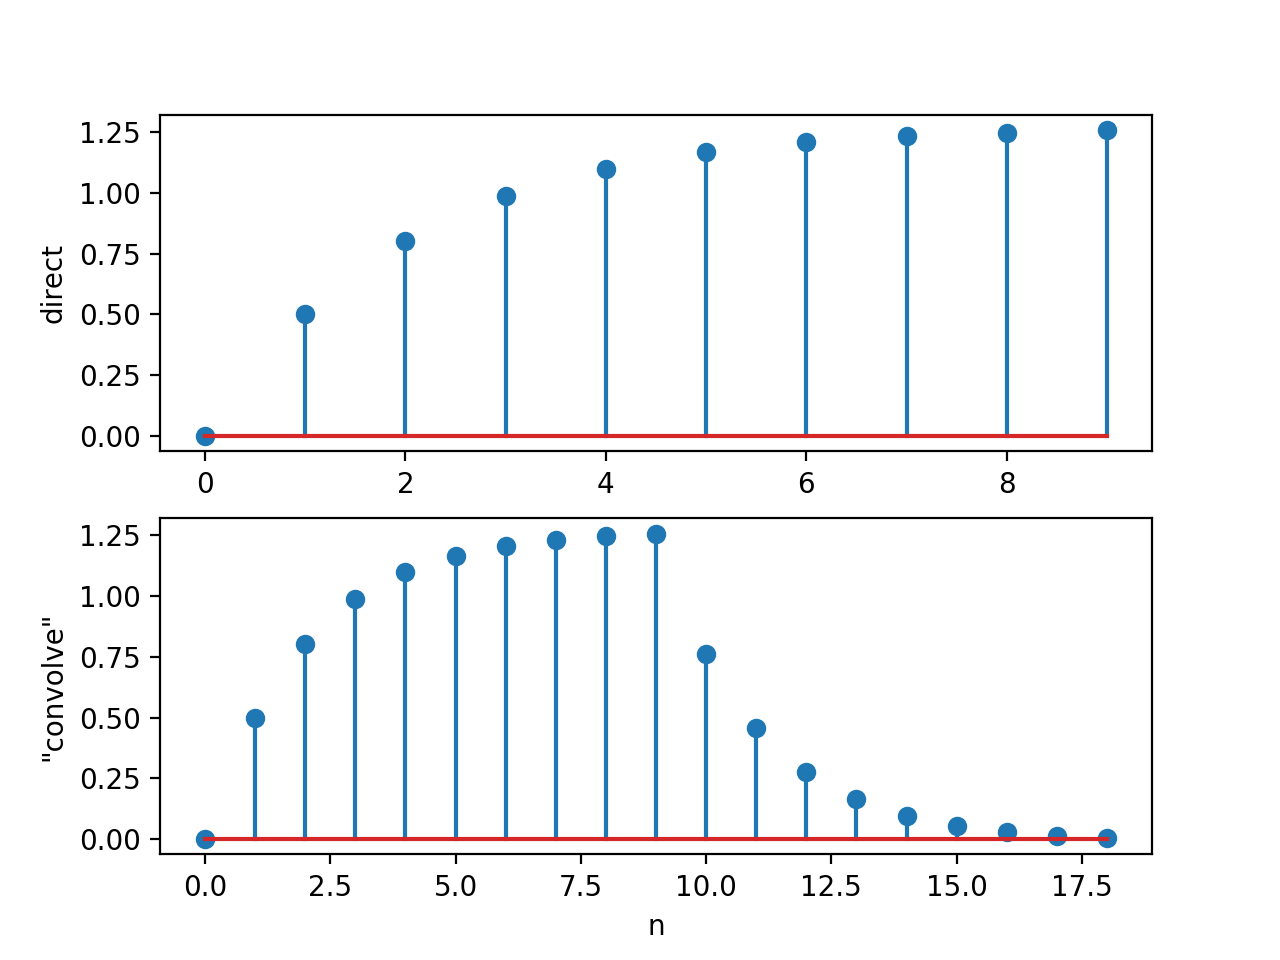

In [179]:
# Explicit discrete convolution sum
yv = np.zeros(nv.shape);
for n in nv:
    for k in nv:
        xcurr = 0 if n-k<0 else xv[n-k];
        yv[n] += hv[k]*xcurr;
yv *= T;
   
# Standard full-length convolution between vectors 
yvf = T*np.convolve(hv, xv, 'full');

# Plot discrete convolution results
fh = plt.figure();
plt.subplot(211);  plt.stem(nv,yv);  plt.ylabel('direct')
plt.subplot(212);  plt.stem(yvf);  plt.xlabel('n');  plt.ylabel('"convolve"')

## Interpretation

The preceeding discussion is admittedly quite technical, but the result is simple.  Suppose we want to find the convolution
$$y(t) = h(t) \ast x(t).$$
If $h(t)$ and $x(t)$ are bandlimited then by the Nyquist criterion they can be represented by samples taken with a sufficiently small $T$.  All that is required is that they be sampled at a frequency that is more than twice the highest frequency present in either.  We can then perform discrete convolution 
$$
y[n] = T h[n] \ast x[n] = T \sum_{k=-\infty}^{\infty} h[k] x[n-k]
$$
on the discretised signals to produce the sampled output $y[n]$.  The corresponding continuous-time output is
$$y(t) = \sum_{n=-\infty}^{\infty} y[n] \delta(t-nT) \ast b_T(t) = y_s(t) \ast b_T(t).$$
The above equation is exact if
$$b_T(t) = \text{sinc}(t/T) = \frac{\sin(\pi t/T)}{\pi t/T}.$$

The code below takes the calculated $y[n]$ and plots the corresponding $y_s(t)$.  The `plot` function applied to the same input effectively 'joins the dots', which as seen before is linear interpolation and corresponds to a low-quality reconstruction filter.  The actual ideal output $y(t)$ calculated analytically is also shown.  Observe that there is some error in the approximation obtained by discrete processing.  This is primarily a consequence of the signals not in fact being bandlimited.  If you decrease $T$ you should observe that the correspondence improves.

<IPython.core.display.Javascript object>


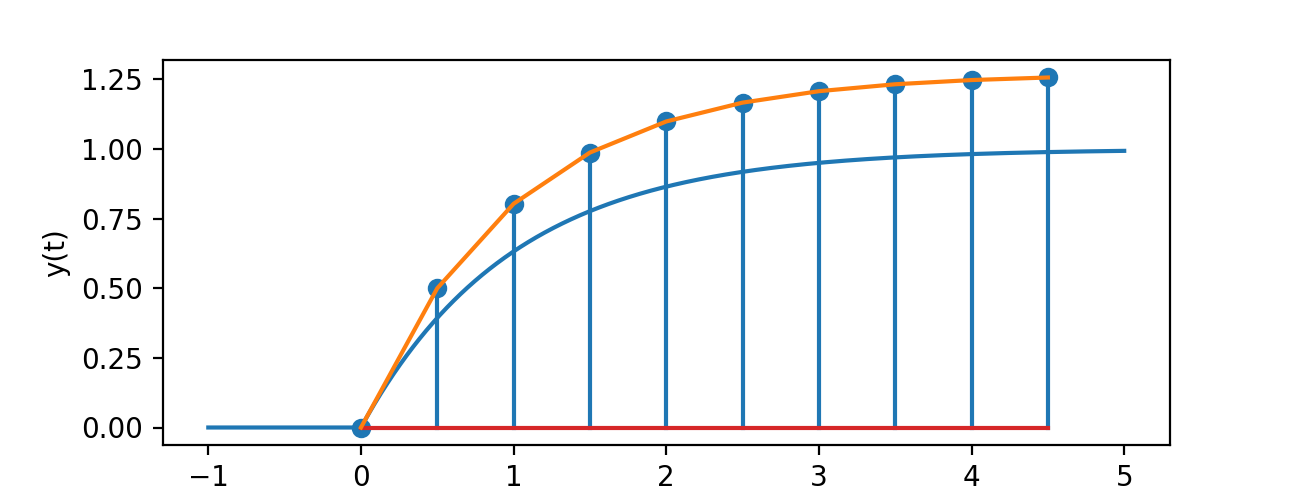

In [180]:
# Plot discrete result and continuous-time counterpart
fh = plt.figure(figsize=(6.5,2.5));
plt.plot(tvp,yvp);  plt.stem(tv,yv);  plt.plot(tv,yv);  plt.xlabel('t');  plt.ylabel('y(t)');

## Approximate impulse input

We cannot formally sample a signal containing an impulse.  However, recall the working definition of the impulse as
$$\delta(t) = \lim_{A \to 0} \frac{1}{A} p_A(t),$$
where $p_A(t)$ is unit pulse with total width $A$ centered on $t=0$.  If we sample the signal with a spacing $T$, and let $T$ become small, then this leads to the approximation
$$\delta(t) \approx \frac{1}{T} p_T(t).$$

The code below demonstrates this concept by using discrete convolution to find the approximate output of the previous system when the input is an impulse at the origin:  $x(t) = \delta(t)$.  The red curve in the first plot shows the finite approximation to the input, along with the samples $x[n] = x(nT)$ starting at $n=0$.  The second plot contains the sample points for the discrete convolution output, along with the linear interpolation of these points (red).  Also shown is the actual impulse response of the system (green), which for this case represents the actual or ideal output.

<IPython.core.display.Javascript object>


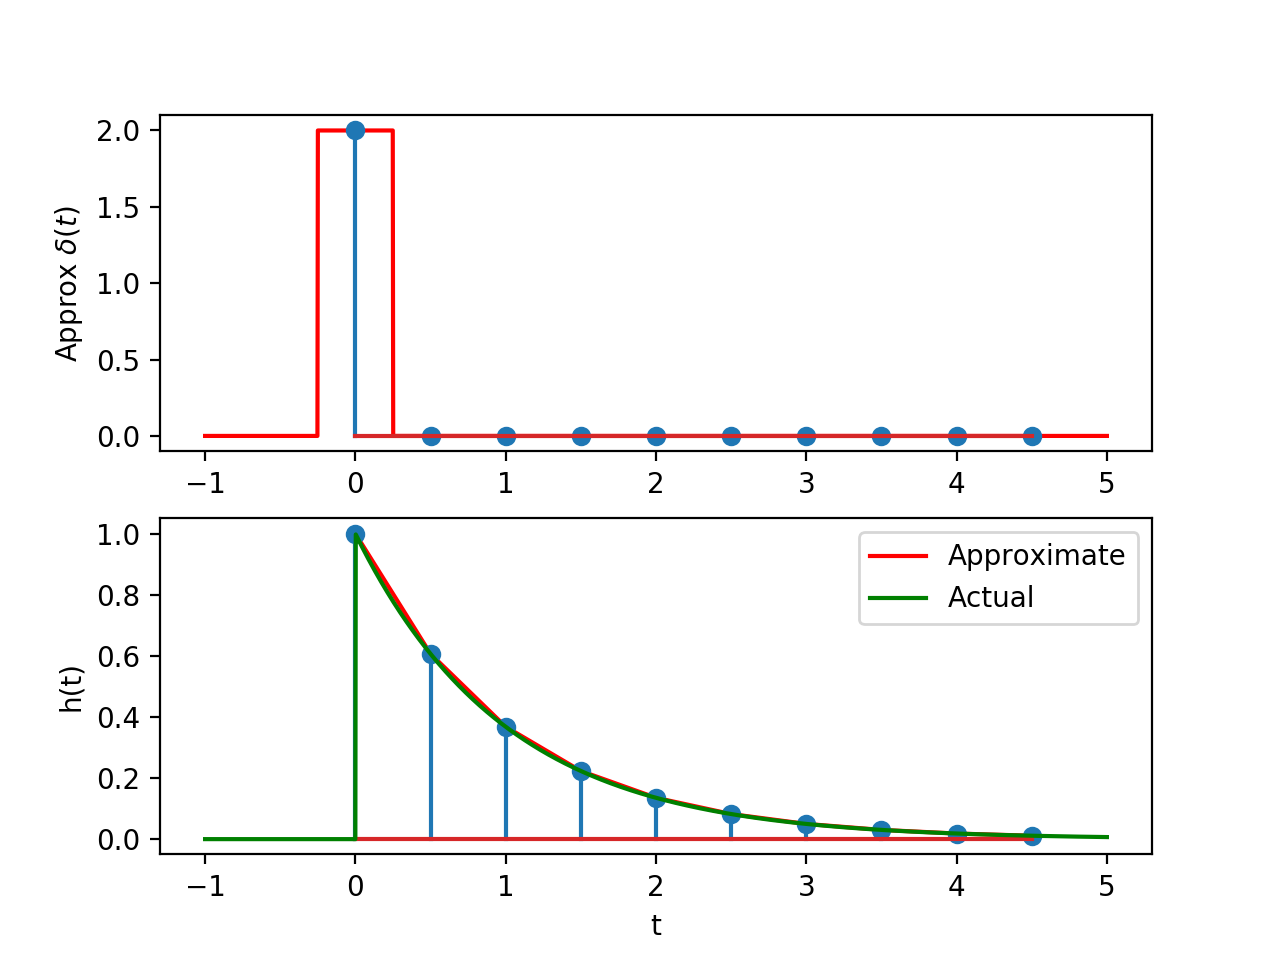

In [198]:
# Approximation to x(t)=delta(t)
xvip = 1/T*np.where(abs(tvp)<=T/2, 1, 0);

# Explicit discrete convolution sum
xvi = np.zeros(xv.shape);  xvi[0] = 1/T;
yvi = np.zeros(nv.shape);
for n in nv:
    for k in nv:
        xcurr = 0 if n-k<0 else xvi[n-k];
        yvi[n] += hv[k]*xcurr;
yvi *= T;

# Plots
fh = plt.figure();
plt.subplot(211);  plt.plot(tvp,xvip,'r-');  plt.stem(tv,xvi);  plt.ylabel('Approx $\delta(t)$');
plt.subplot(212);  plt.plot(tv,yvi,'r-',label="Approximate");  plt.stem(tv,yvi);  
plt.plot(tvp,hvp,'g-',label="Actual");  plt.ylabel('h(t)');  plt.xlabel('t');  plt.legend();

# Tasks

These tasks involve writing code, or modifying existing code, to meet the objectives described.

1.  The previous code snippets use samples with spacing $T = 0.5$ to approximate the output $y(t)$ from a system with impulse response $h(t) = e^{-t} u(t)$ when the input is $x(t) = u(t)$.  Repeat this with a spacing of $T=0.1$ in the discretisation.  Generate a plot that shows the approximate output $y(t)$ using linear interpolation for this case, and on the same set of axes include the actual output calculated analytically.  The domain of your plot should span $t=-1$ to $t=5$.<br><br>

2.  Repeat the previous task but using a system with the highpass impulse response $h(t) = \delta(t) - e^{-t} u(t)$.<br><br>

3.  An underdamped second-order system with transfer function
$$
H(s) = \frac{K \omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2}
$$
has impulse response
$$
h(t) = \frac{\omega_n}{\sqrt{1-\zeta^2}} e^{-\zeta \omega_n t} 
\sin(\omega_n \sqrt{1-\zeta^2} t) u(t)
$$
when $\zeta<1$.  Here $K$ is the *gain*, $\zeta$ is called the *damping ratio*, and $\omega_n$ is the *natural frequency* of the system.  On one set of axes make a plot of this impulse response for $K=1$, $\omega_n = 3$ and the three cases $\zeta = 0.25, 0.5, 0.99$.  Your plot should span the domain $t=-1$ to $t=10$.  Then, using discrete-time convolution with $T=0.1$, find the approximate step responses for each of the three cases.  Plot these responses on one set of coordinate axes over the same domain $t=-1$ to $t=10$.